## Investigating the Impact of Convolutional Layer Configurations on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of different convolutional layer configurations on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**

To conduct the experiment, we employ a sequential EEG model architecture with varying numbers of convolutional layers. Each convolutional layer utilizes a specific number of filters and kernel sizes. The models are trained and evaluated using cross-validation.

A total of 6 experiments are conducted based on the provided configurations.


Through an iterative process, we evaluate multiple configurations of convolutional layers. For each configuration, we train and evaluate the models on different folds. The training histories, including loss, accuracy, validation loss, and validation accuracy, are recorded(logged) for analysis.

The experiment involves training a significant number of models, depending on the number of convolutional layer configurations and the number of folds in cross-validation. The accuracy of each model on the validation set is monitored and logged.

The results provide insights into the impact of convolutional layer configurations on EEG classification tasks. By assessing the relationship between the number of convolutional layers and accuracy, we aim to identify the optimal configuration that yields improved performance in EEG analysis.

The experiment outcomes and accuracy results contribute to a comprehensive understanding of the influence of convolutional layer configurations on EEG classification performance. The findings can guide the design and development of more effective models for EEG-based applications.

In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_CNN_E04
%ls

/content/drive/MyDrive/ED_Experiments/ED_CNN_E04


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

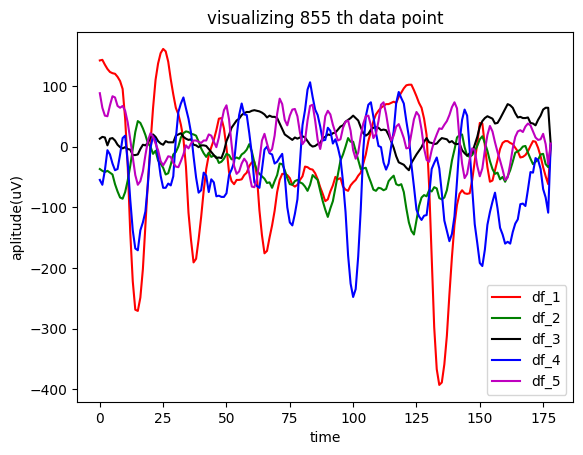

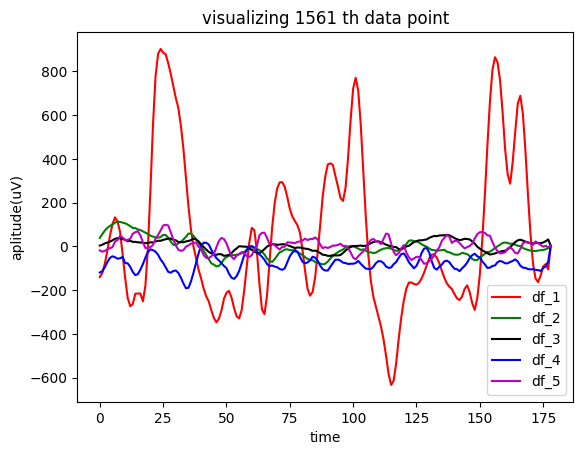

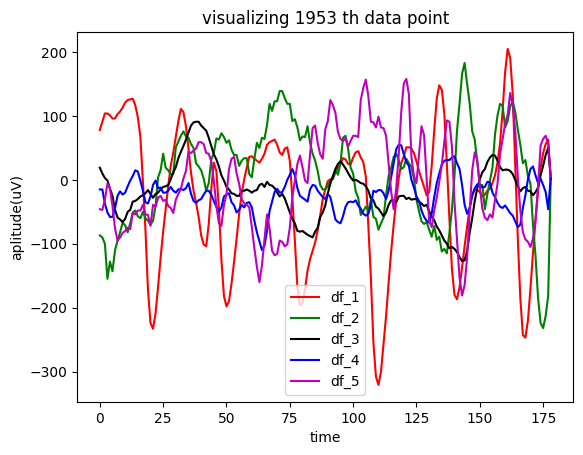

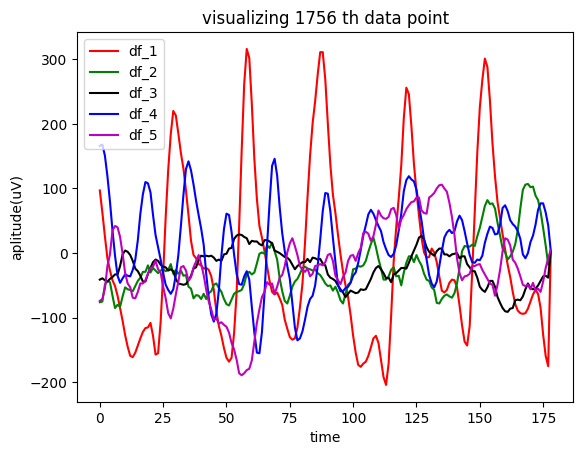

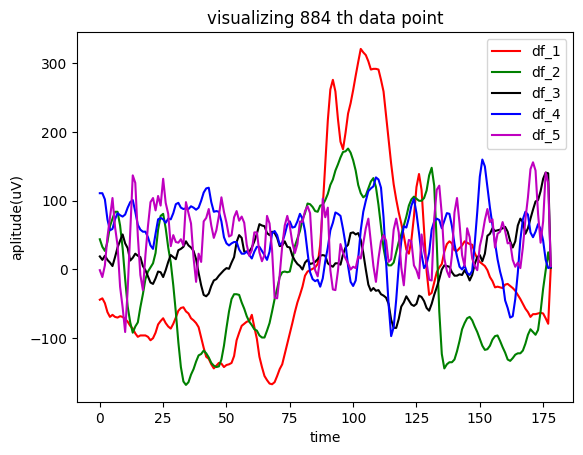

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the number of conv layers

```
layers = [1, 2, 3, 4, 5, 6]


```


In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape, conv_layers):
#         super(eegClassifier, self).__init__()

#         self.conv_layers = []
#         for i in range(conv_layers):
#             filters = 128 * 2**i
#             kernel_size = 5 if i == 0 else 3
#             padding = 'same' if i == 0 else 'valid'
#             conv_layer = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')
#             self.conv_layers.append(conv_layer)
#             bn_layer = BatchNormalization()
#             self.__setattr__(f'bn_{i}', bn_layer)
#             max_pool_layer = layers.MaxPooling1D(2, padding='same')
#             self.__setattr__(f'max_pool_{i}', max_pool_layer)

#         self.flatten = Flatten()

#         self.dense_1 = Dense(128)
#         self.dense_2 = Dense(32)

#         self.output_dense = Dense(1, activation='sigmoid')

#     def call(self, inputs):
#         x = inputs
#         for i in range(len(self.conv_layers)):
#             x = self.conv_layers[i](x)
#             x = self.__getattribute__(f'bn_{i}')(x)
#             x = self.__getattribute__(f'max_pool_{i}')(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = tf.nn.relu(x)
#         x = self.dense_2(x)
#         x = tf.nn.relu(x)
#         return self.output_dense(x)


In [ ]:
def create_sequential_eeg_model(input_shape, conv_layers):
    model = keras.Sequential()

    for i in range(conv_layers):
        filters = 128 * 2**i
        kernel_size = 5 if i == 0 else 3
        padding = 'same' if i == 0 else 'valid'

        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(2, padding='same'))

    model.add(layers.Flatten())

    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    model.add(layers.Dense(32))
    model.add(layers.ReLU())

    model.add(layers.Dense(1, activation='sigmoid'))

    return model



---- fold = 1 ---- conv layers = 1-------

72/72 [==============================] - 0s 2ms/step - loss: 0.2165 - accuracy: 0.9752
model_conv_layers = 1 Fold = 1 accuracy: 0.9752174019813538


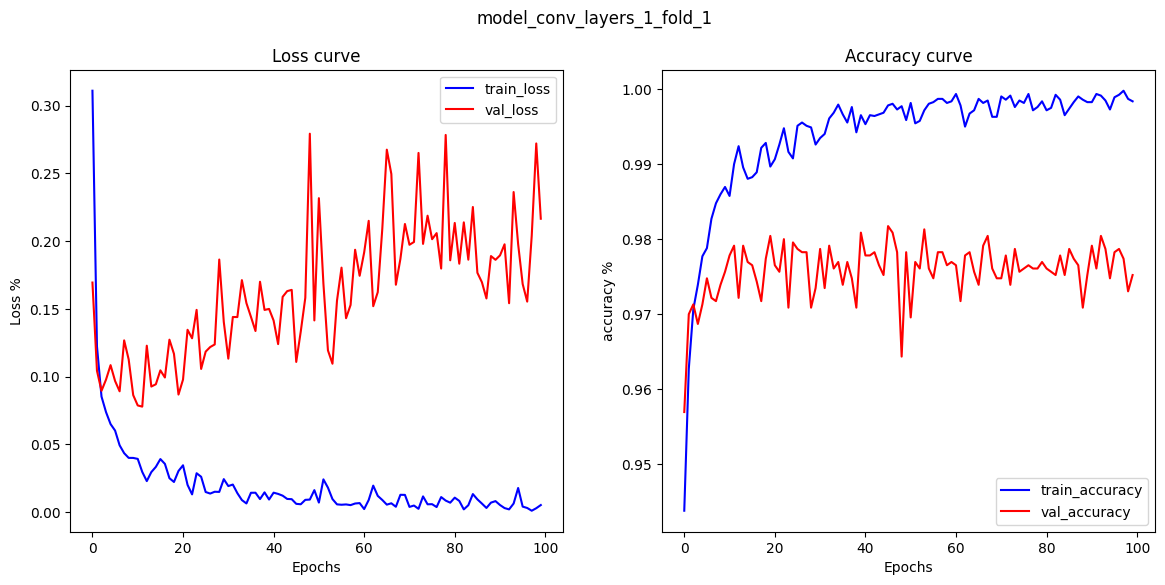



---- fold = 2 ---- conv layers = 1-------

72/72 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.9687
model_conv_layers = 1 Fold = 2 accuracy: 0.9686956405639648


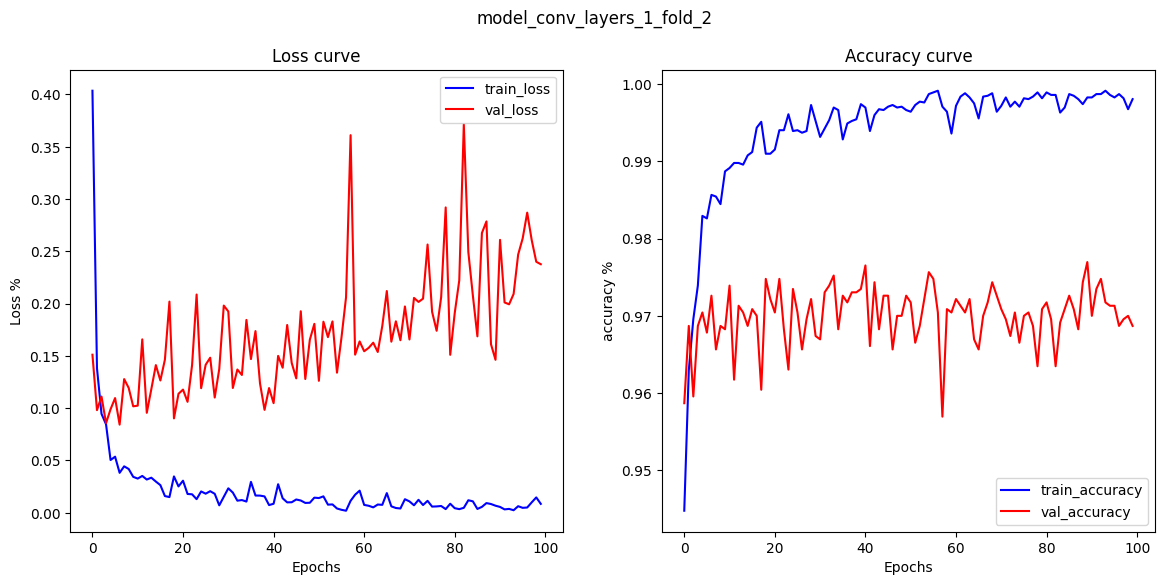



---- fold = 3 ---- conv layers = 1-------

72/72 [==============================] - 0s 2ms/step - loss: 0.1387 - accuracy: 0.9752
model_conv_layers = 1 Fold = 3 accuracy: 0.9752174019813538


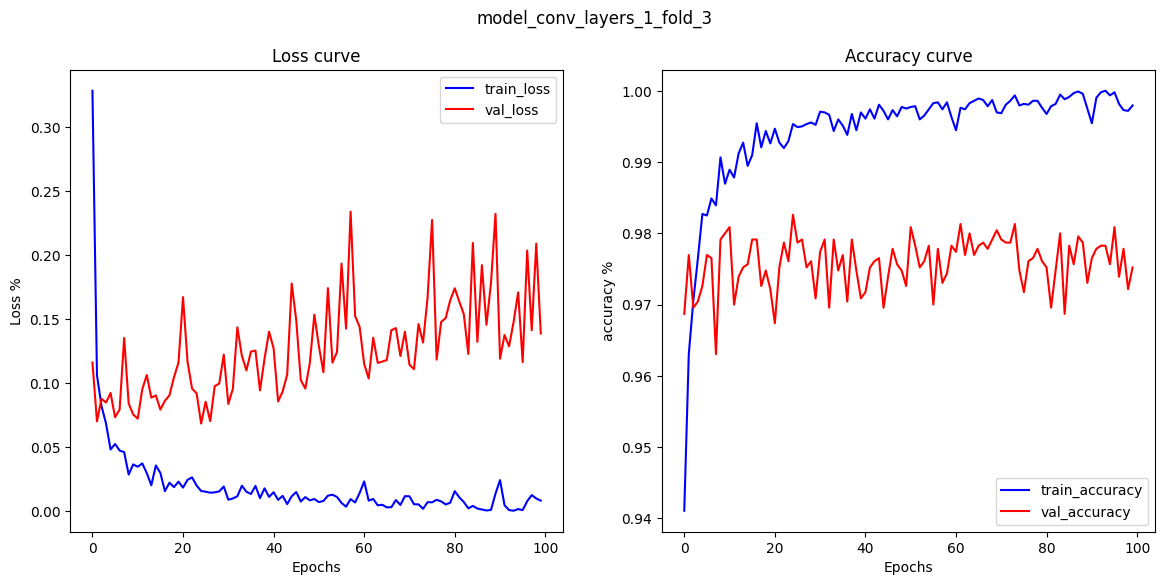



---- fold = 4 ---- conv layers = 1-------

72/72 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9739
model_conv_layers = 1 Fold = 4 accuracy: 0.9739130139350891


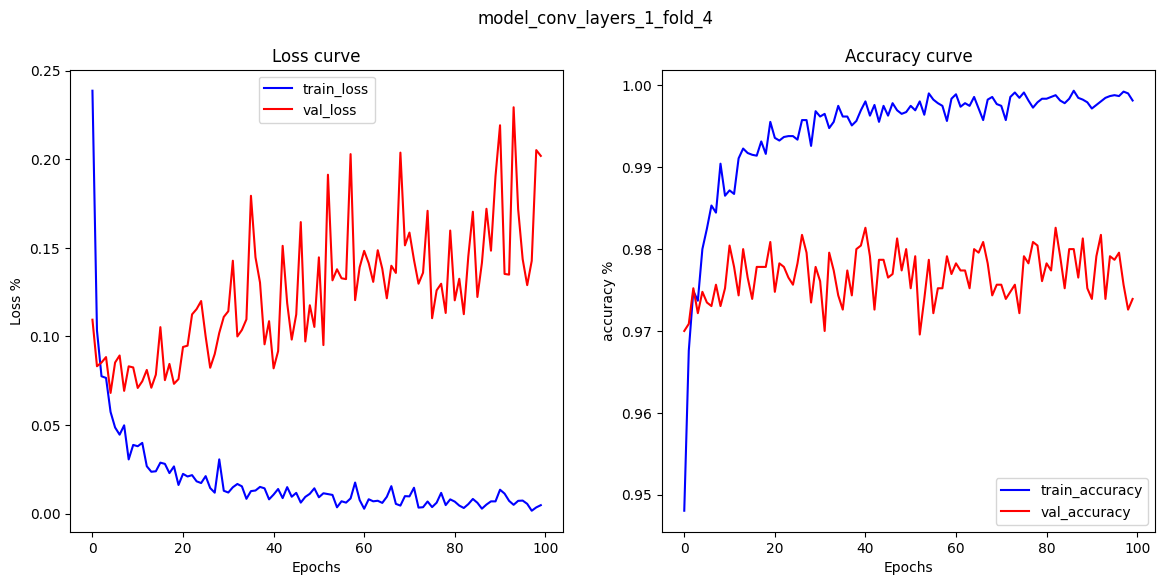



---- fold = 5 ---- conv layers = 1-------

72/72 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9735
model_conv_layers = 1 Fold = 5 accuracy: 0.9734782576560974


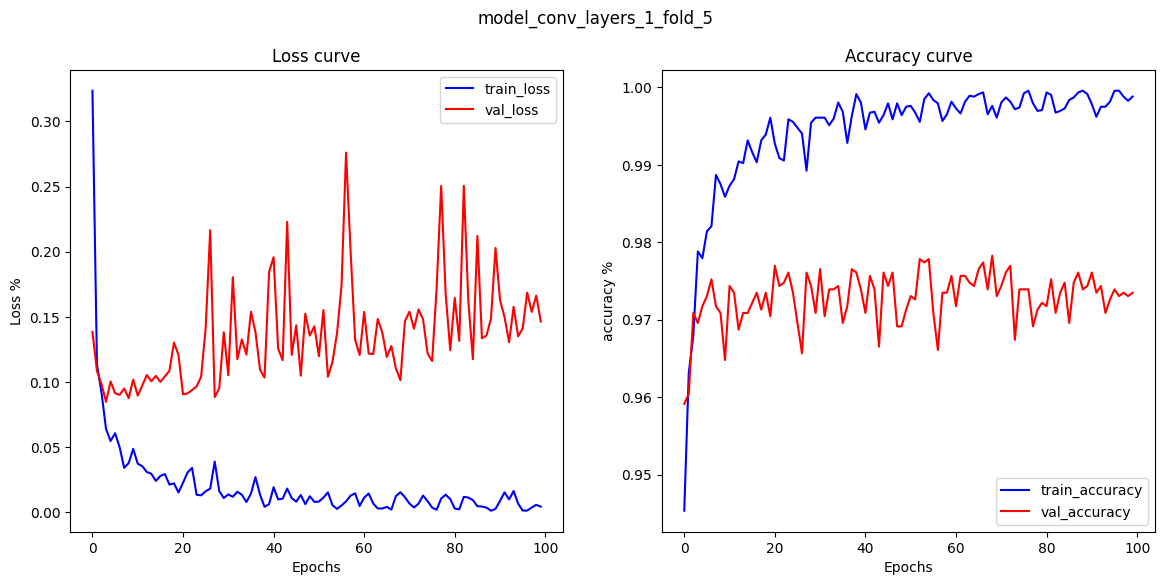

Mean Accuracy: 0.9733043432235717


---- fold = 1 ---- conv layers = 2-------

72/72 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9817
model_conv_layers = 2 Fold = 1 accuracy: 0.9817391037940979


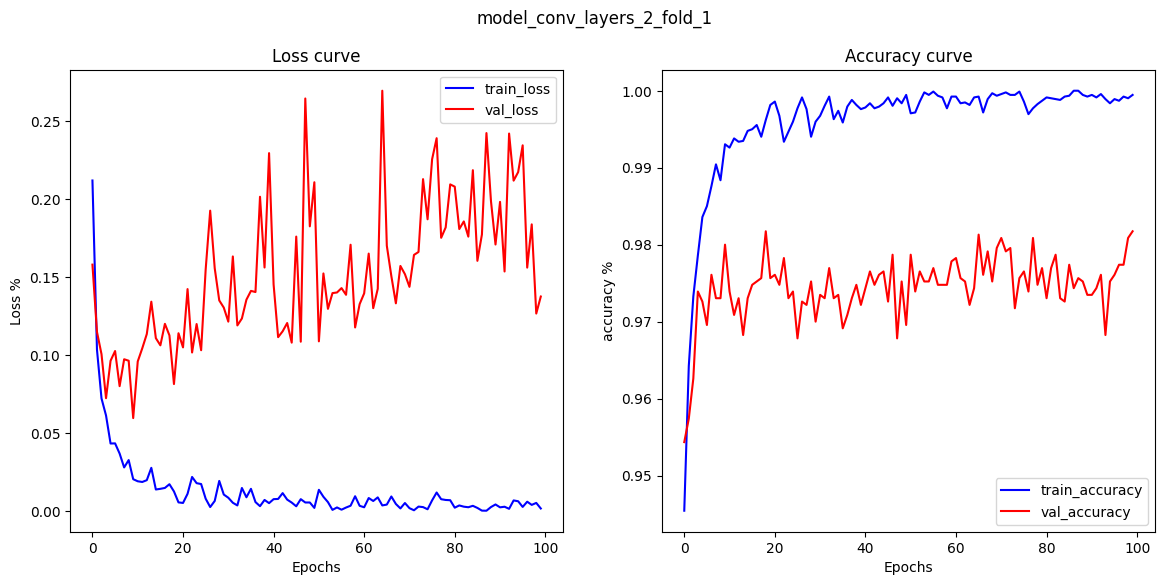



---- fold = 2 ---- conv layers = 2-------

72/72 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9722
model_conv_layers = 2 Fold = 2 accuracy: 0.9721739292144775


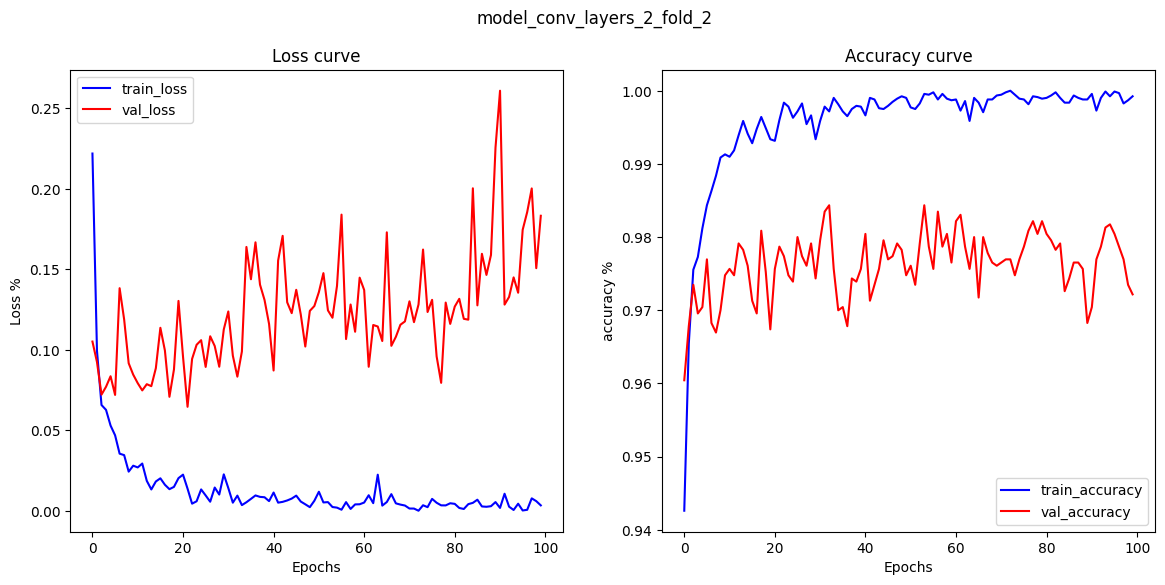



---- fold = 3 ---- conv layers = 2-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9835
model_conv_layers = 2 Fold = 3 accuracy: 0.9834782481193542


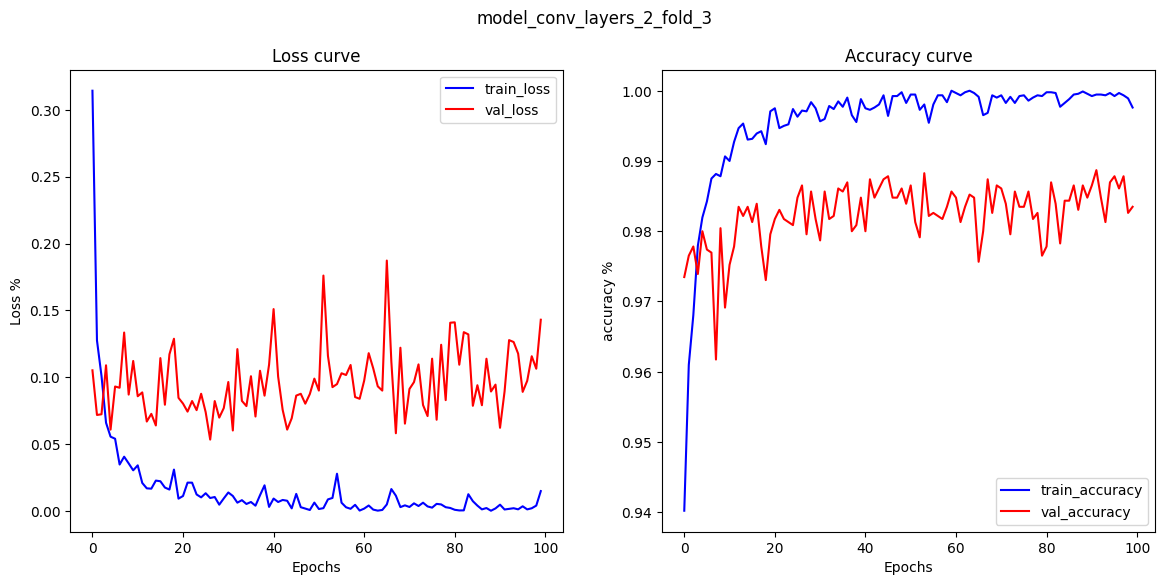



---- fold = 4 ---- conv layers = 2-------

72/72 [==============================] - 0s 3ms/step - loss: 0.1096 - accuracy: 0.9830
model_conv_layers = 2 Fold = 4 accuracy: 0.9830434918403625


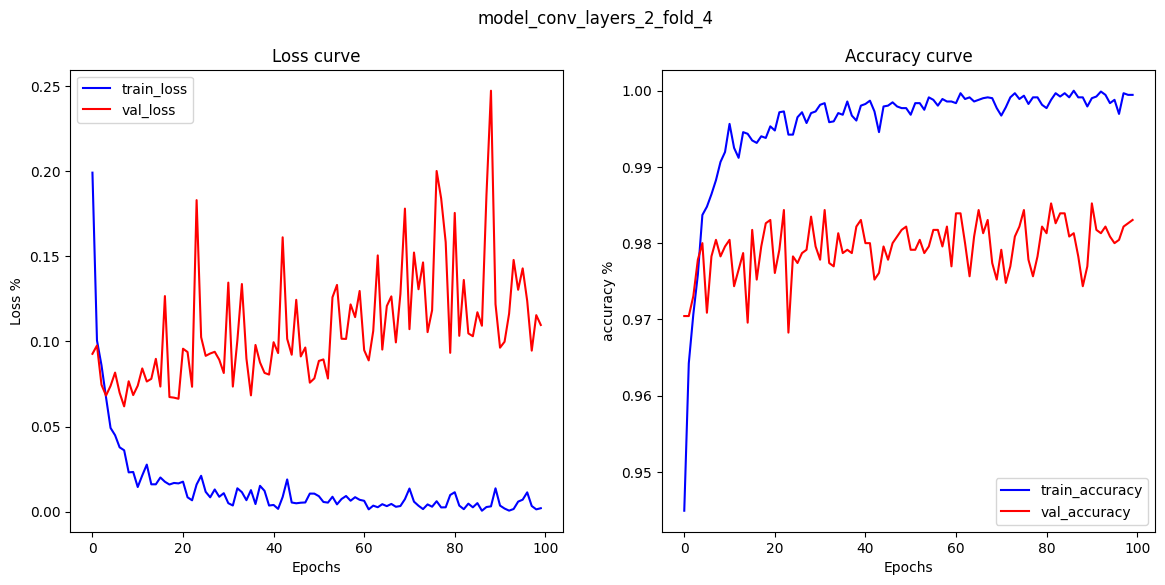



---- fold = 5 ---- conv layers = 2-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9778
model_conv_layers = 2 Fold = 5 accuracy: 0.9778260588645935


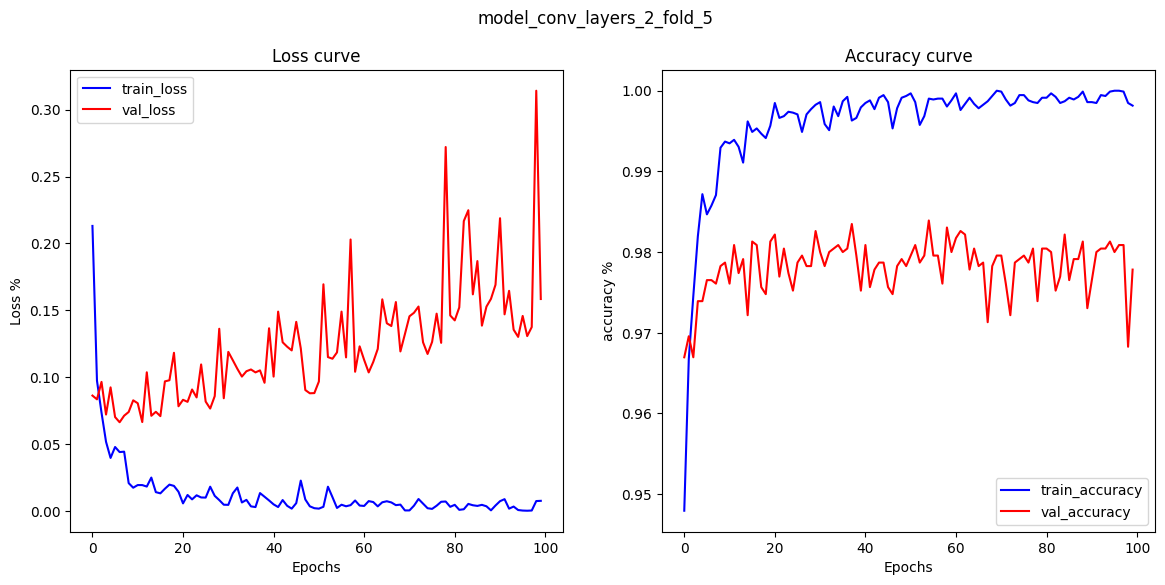

Mean Accuracy: 0.9796521663665771


---- fold = 1 ---- conv layers = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1158 - accuracy: 0.9857
model_conv_layers = 3 Fold = 1 accuracy: 0.9856521487236023


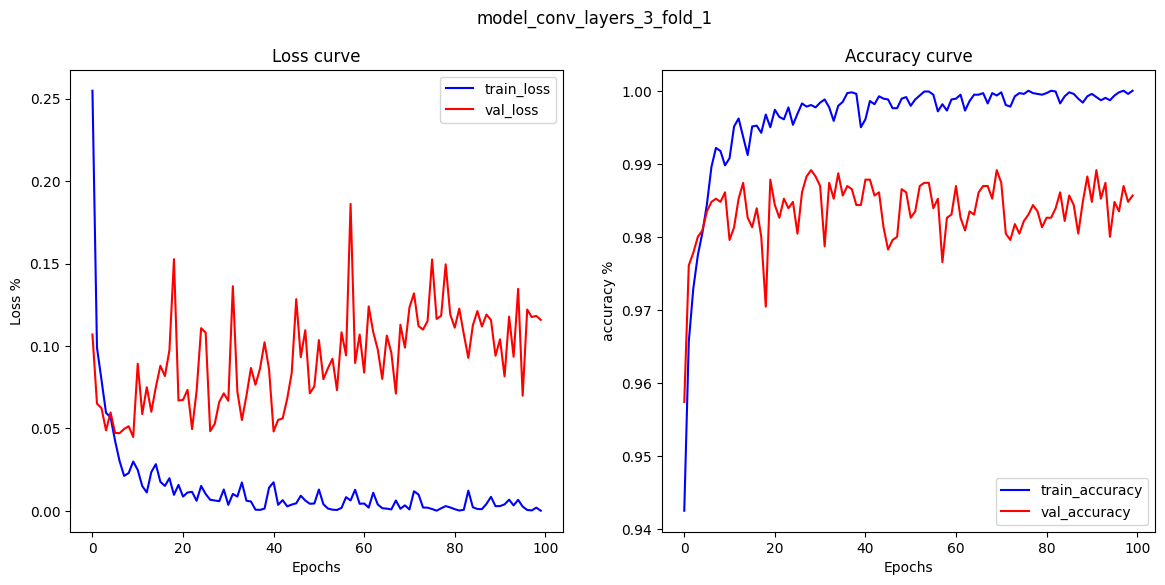



---- fold = 2 ---- conv layers = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.0588 - accuracy: 0.9887
model_conv_layers = 3 Fold = 2 accuracy: 0.9886956810951233


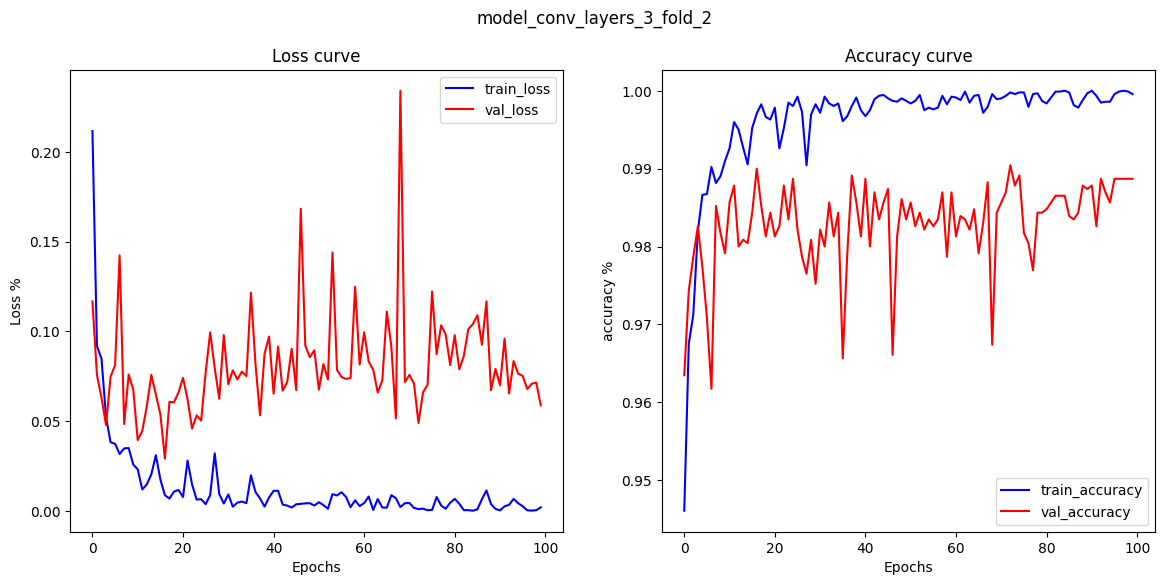



---- fold = 3 ---- conv layers = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.9917
model_conv_layers = 3 Fold = 3 accuracy: 0.9917391538619995


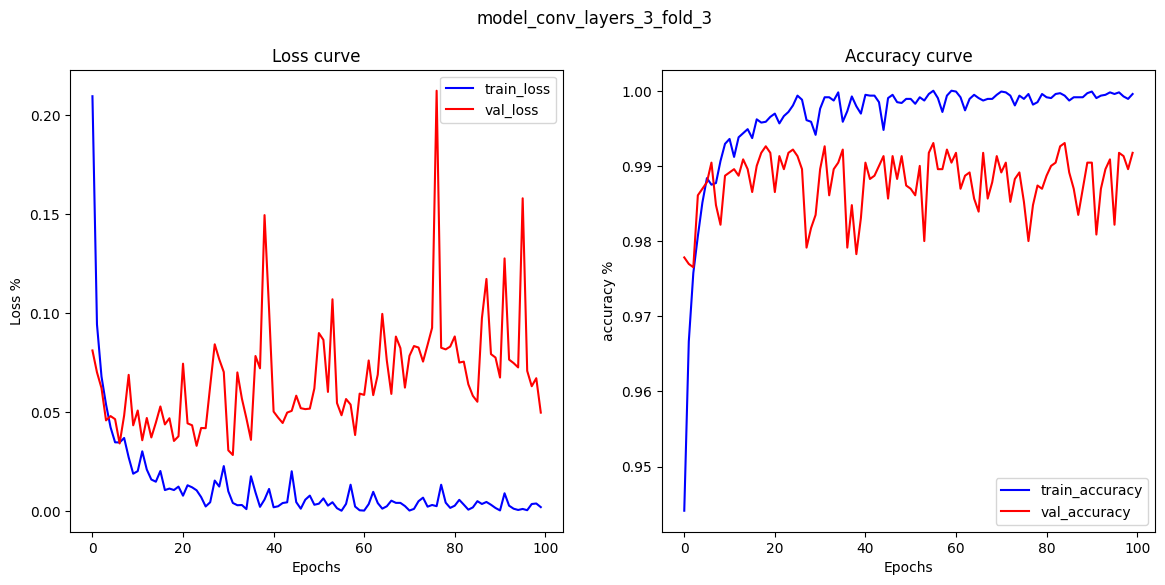



---- fold = 4 ---- conv layers = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1531 - accuracy: 0.9848
model_conv_layers = 3 Fold = 4 accuracy: 0.9847826361656189


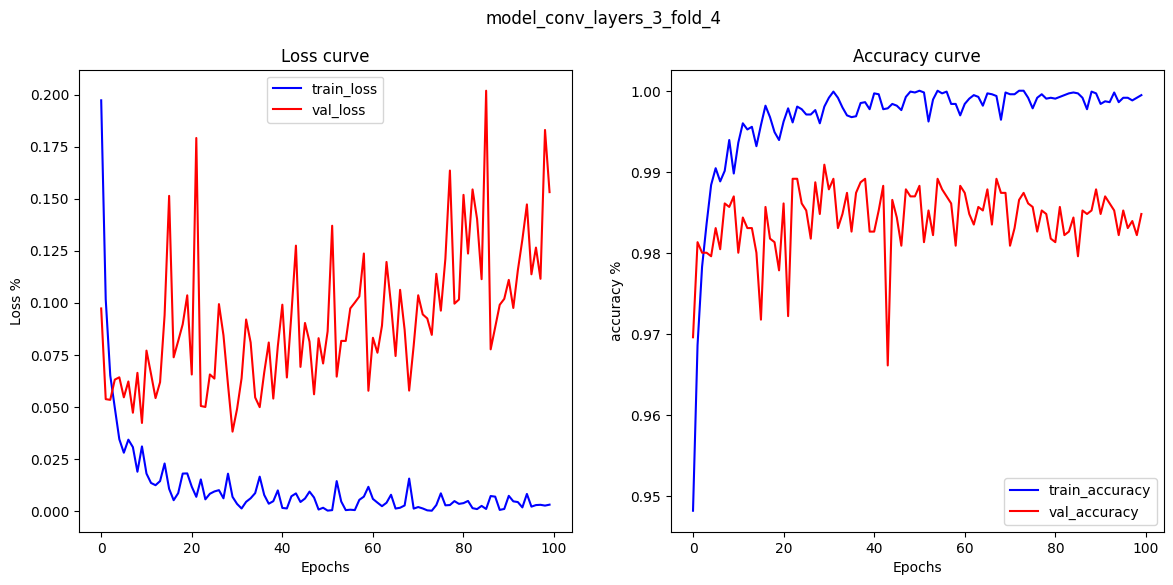



---- fold = 5 ---- conv layers = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.0797 - accuracy: 0.9848
model_conv_layers = 3 Fold = 5 accuracy: 0.9847826361656189


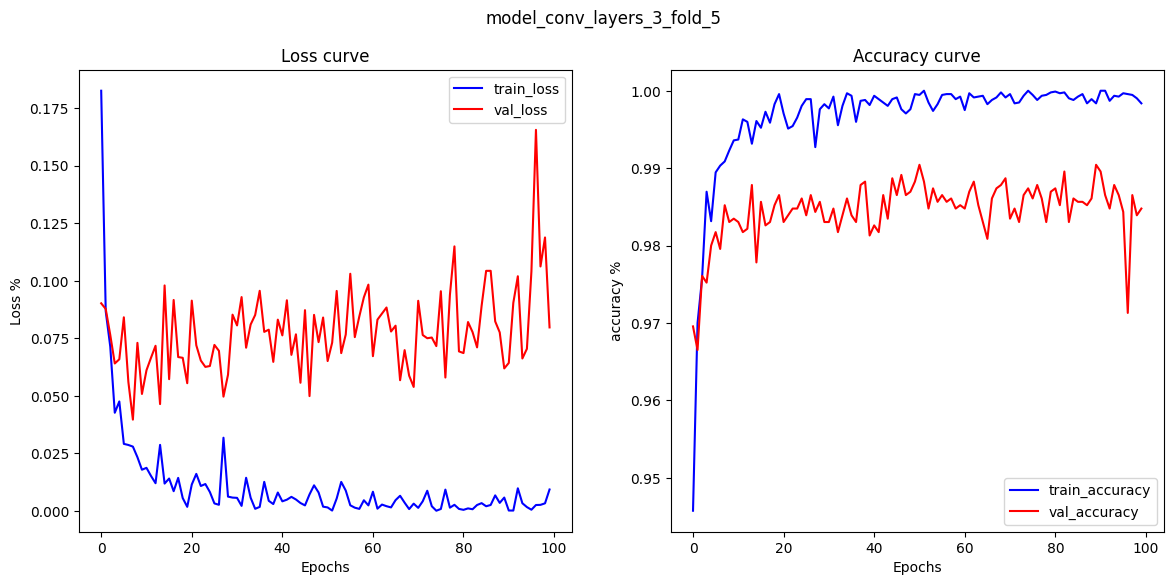

Mean Accuracy: 0.9871304512023926


---- fold = 1 ---- conv layers = 4-------

72/72 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 0.9878
model_conv_layers = 4 Fold = 1 accuracy: 0.9878261089324951


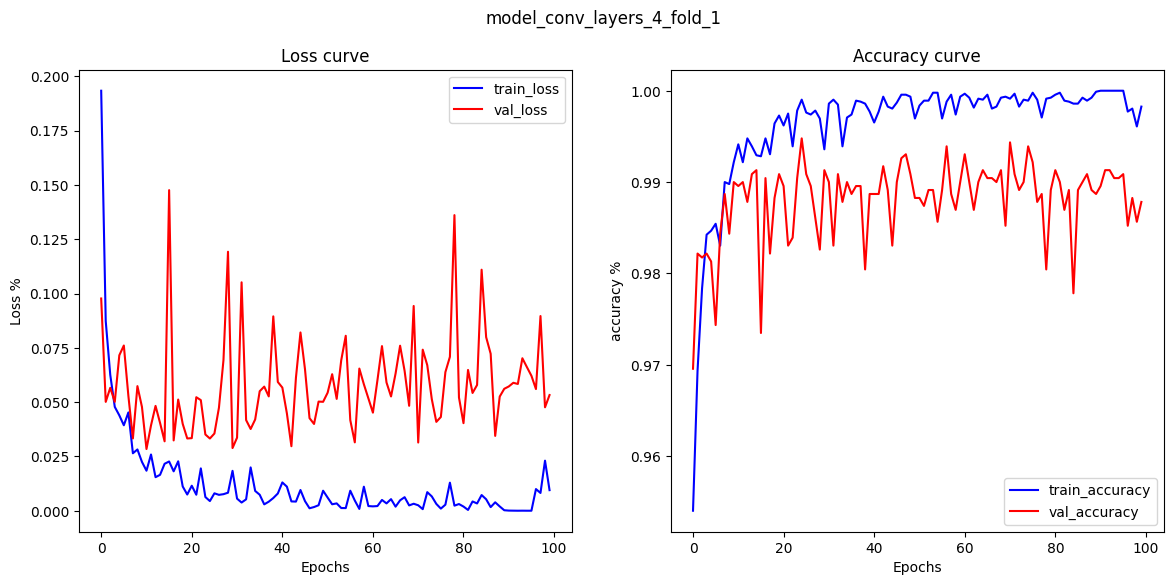



---- fold = 2 ---- conv layers = 4-------

72/72 [==============================] - 0s 4ms/step - loss: 0.0337 - accuracy: 0.9926
model_conv_layers = 4 Fold = 2 accuracy: 0.9926086664199829


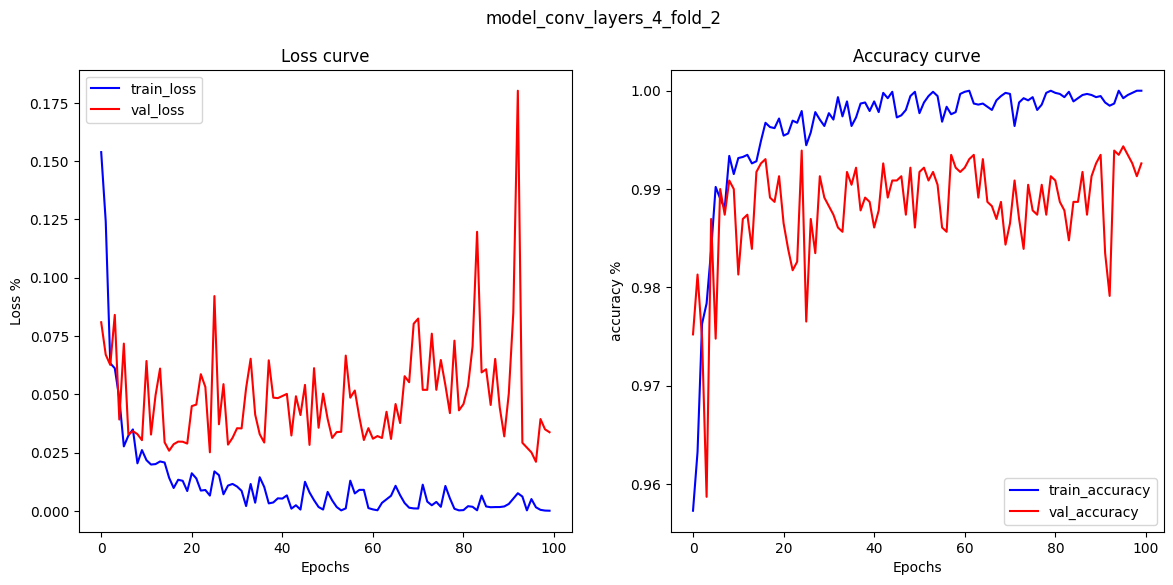



---- fold = 3 ---- conv layers = 4-------

72/72 [==============================] - 0s 6ms/step - loss: 0.0769 - accuracy: 0.9917
model_conv_layers = 4 Fold = 3 accuracy: 0.9917391538619995


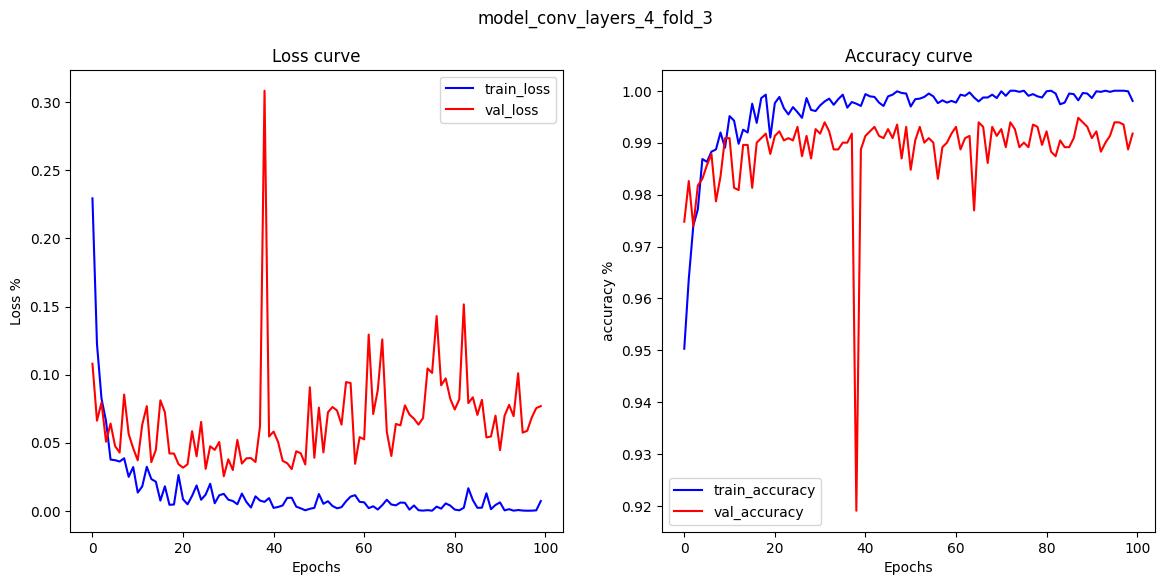



---- fold = 4 ---- conv layers = 4-------

72/72 [==============================] - 0s 6ms/step - loss: 0.0964 - accuracy: 0.9887
model_conv_layers = 4 Fold = 4 accuracy: 0.9886956810951233


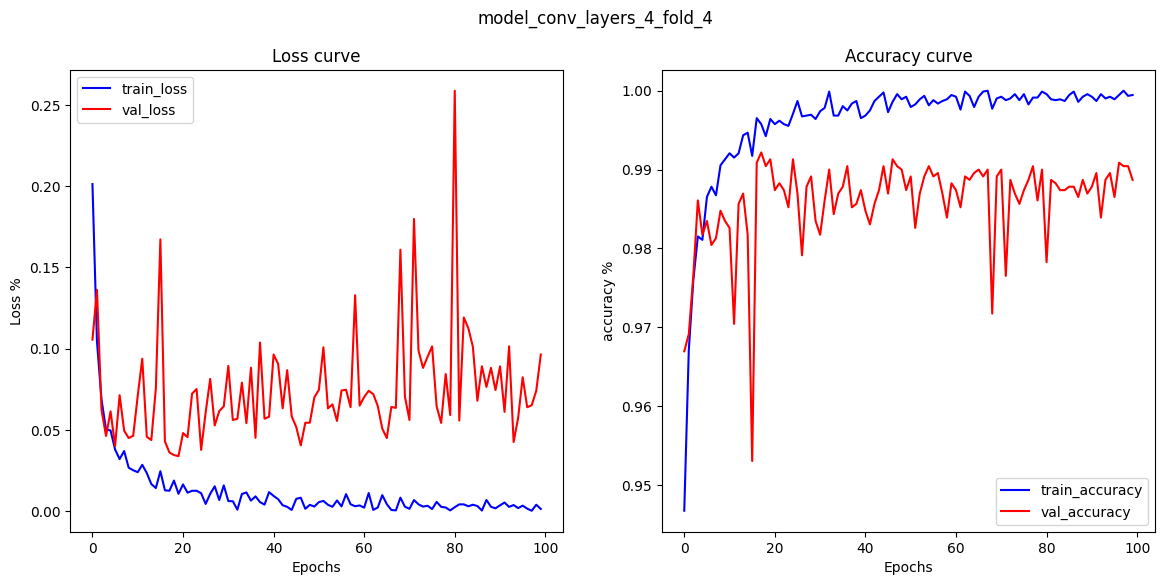



---- fold = 5 ---- conv layers = 4-------

72/72 [==============================] - 0s 6ms/step - loss: 0.1491 - accuracy: 0.9900
model_conv_layers = 4 Fold = 5 accuracy: 0.9900000095367432


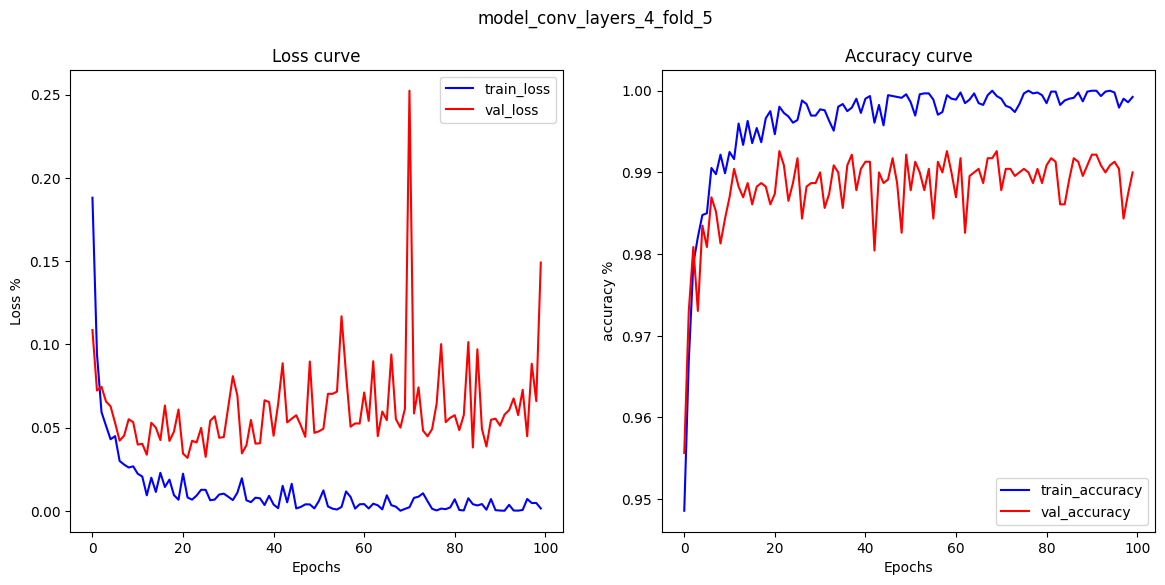

Mean Accuracy: 0.9901739239692688


---- fold = 1 ---- conv layers = 5-------

72/72 [==============================] - 1s 8ms/step - loss: 0.0892 - accuracy: 0.9930
model_conv_layers = 5 Fold = 1 accuracy: 0.9930434823036194


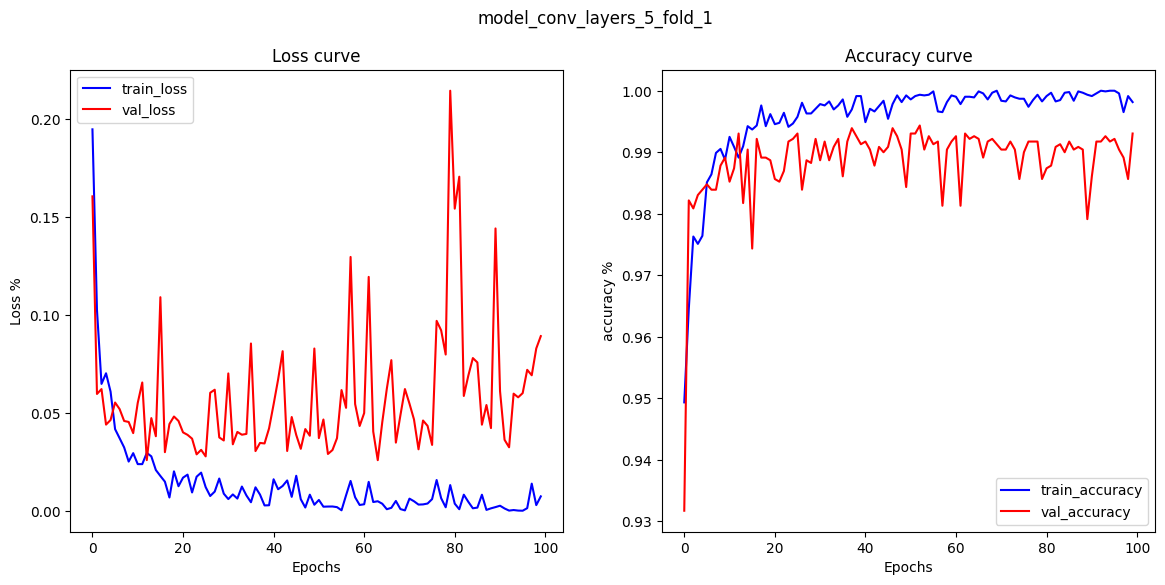



---- fold = 2 ---- conv layers = 5-------

72/72 [==============================] - 1s 8ms/step - loss: 0.0217 - accuracy: 0.9930
model_conv_layers = 5 Fold = 2 accuracy: 0.9930434823036194


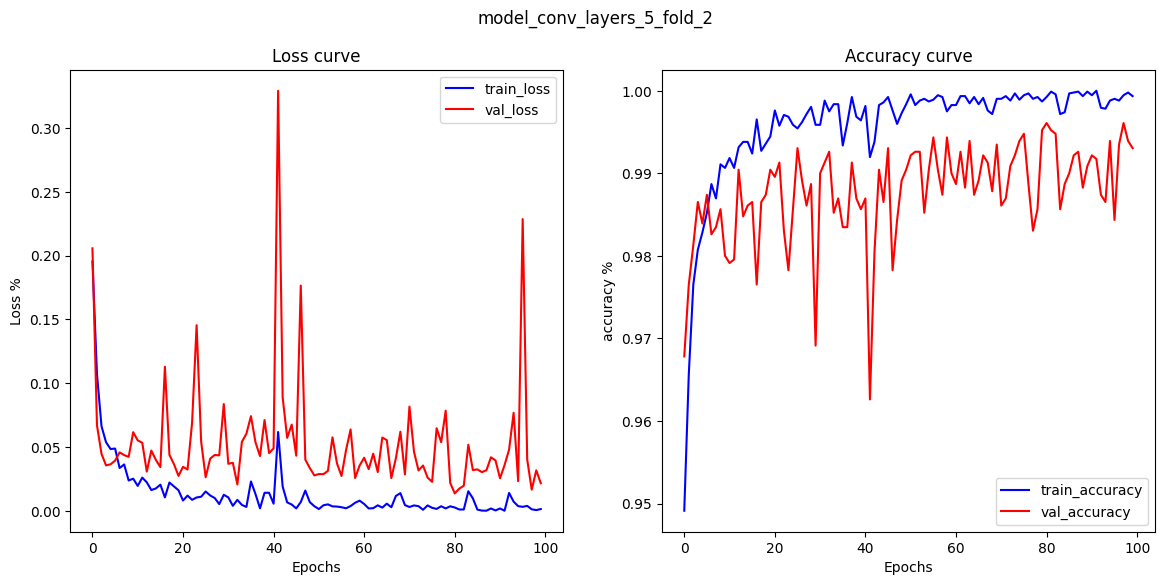



---- fold = 3 ---- conv layers = 5-------

72/72 [==============================] - 1s 7ms/step - loss: 0.0984 - accuracy: 0.9930
model_conv_layers = 5 Fold = 3 accuracy: 0.9930434823036194


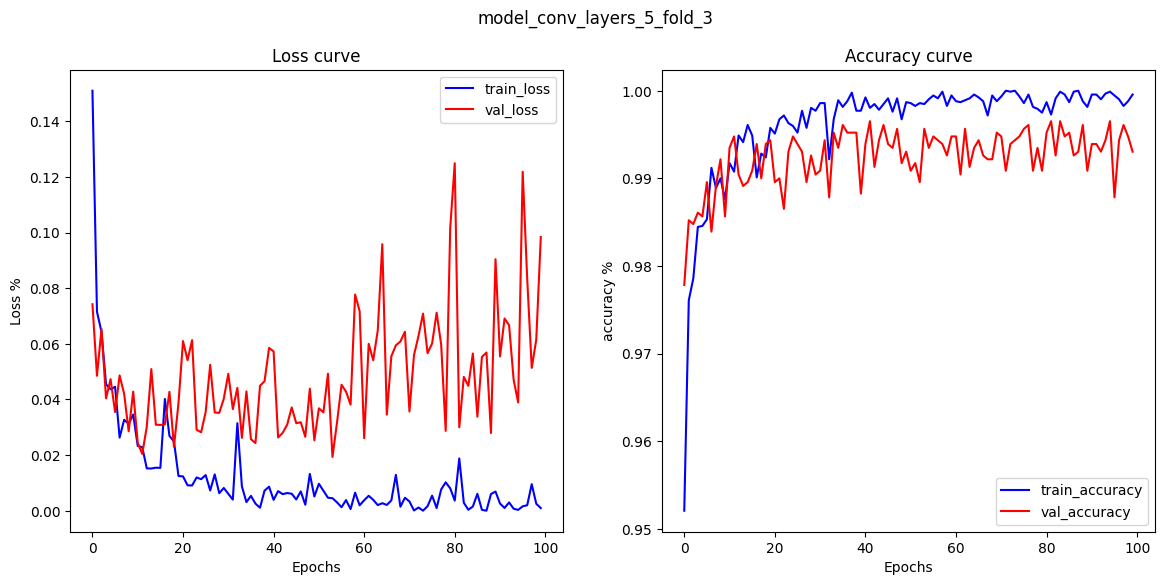



---- fold = 4 ---- conv layers = 5-------

72/72 [==============================] - 1s 7ms/step - loss: 0.0531 - accuracy: 0.9922
model_conv_layers = 5 Fold = 4 accuracy: 0.9921739101409912


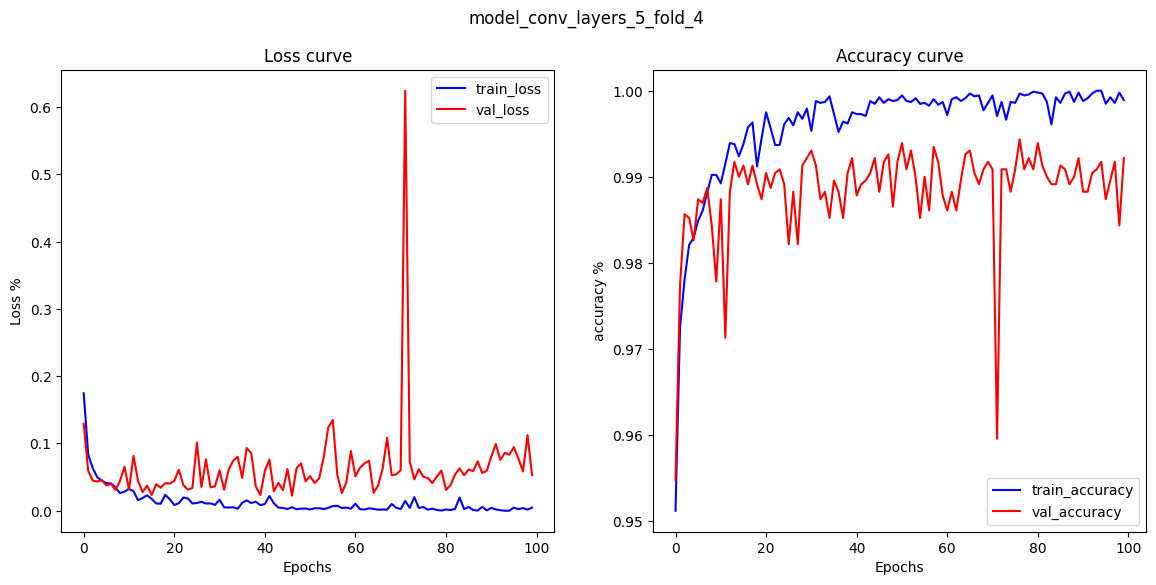



---- fold = 5 ---- conv layers = 5-------

72/72 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9935
model_conv_layers = 5 Fold = 5 accuracy: 0.9934782385826111


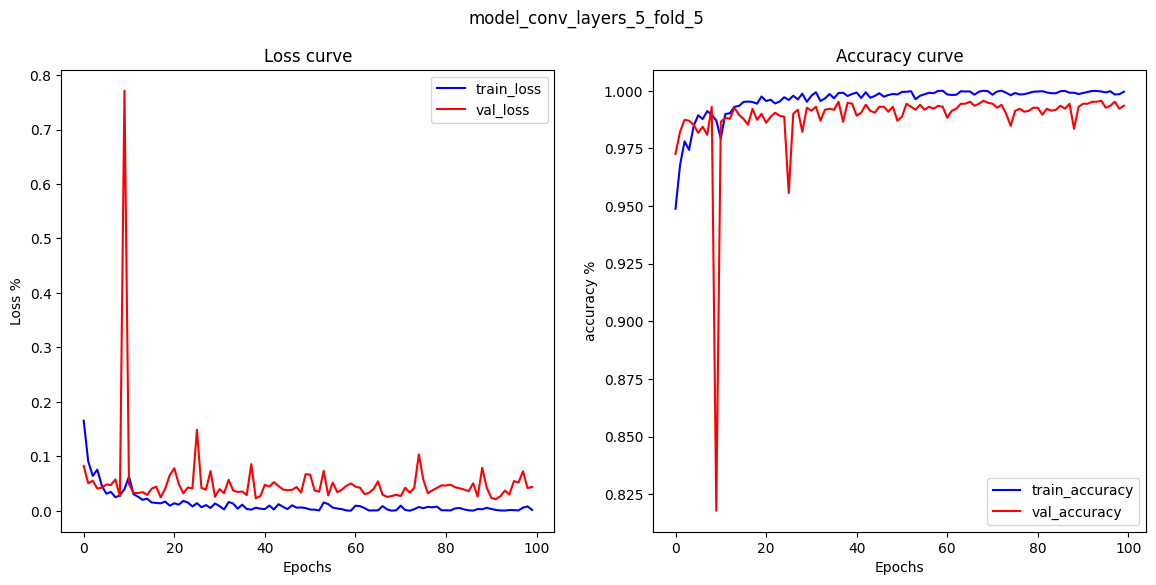

Mean Accuracy: 0.9929565191268921


---- fold = 1 ---- conv layers = 6-------

72/72 [==============================] - 1s 11ms/step - loss: 0.0324 - accuracy: 0.9952
model_conv_layers = 6 Fold = 1 accuracy: 0.9952173829078674


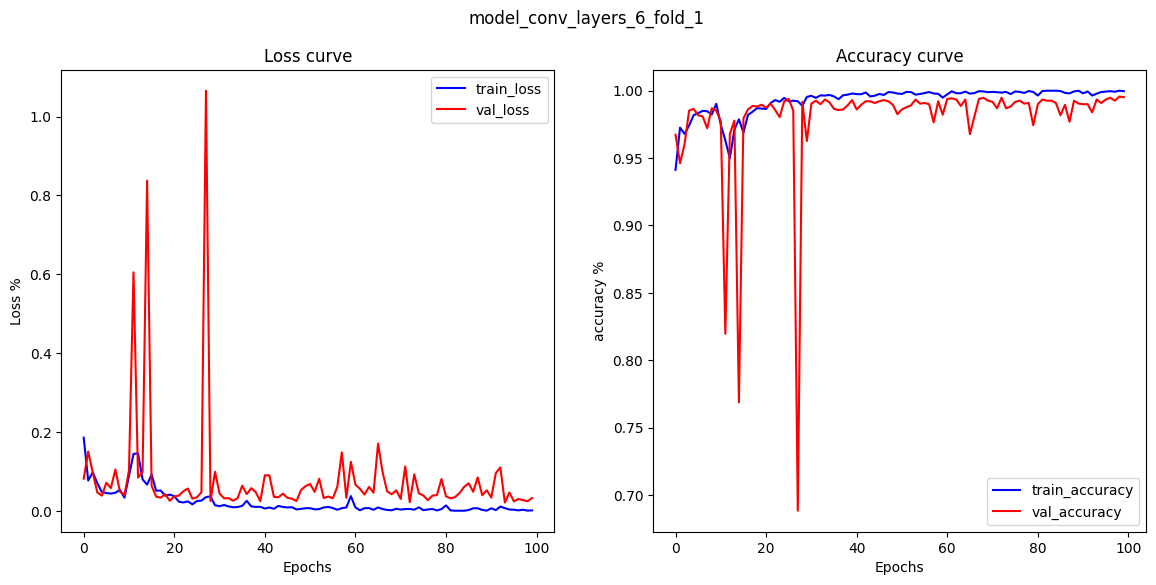



---- fold = 2 ---- conv layers = 6-------

72/72 [==============================] - 1s 10ms/step - loss: 0.0619 - accuracy: 0.9926
model_conv_layers = 6 Fold = 2 accuracy: 0.9926086664199829


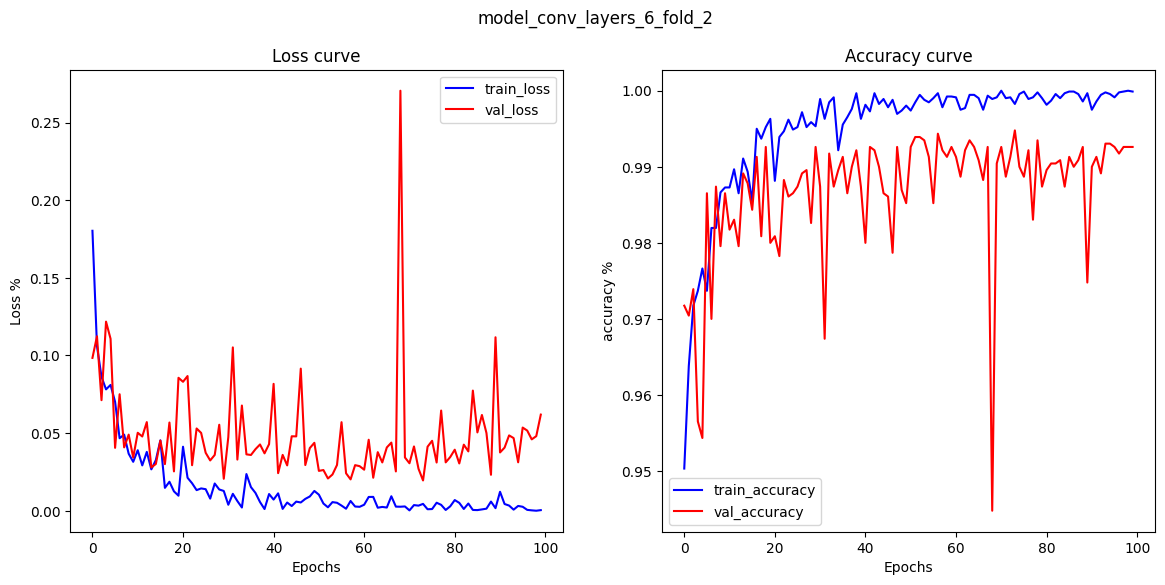



---- fold = 3 ---- conv layers = 6-------

72/72 [==============================] - 1s 11ms/step - loss: 0.1247 - accuracy: 0.9870
model_conv_layers = 6 Fold = 3 accuracy: 0.9869565367698669


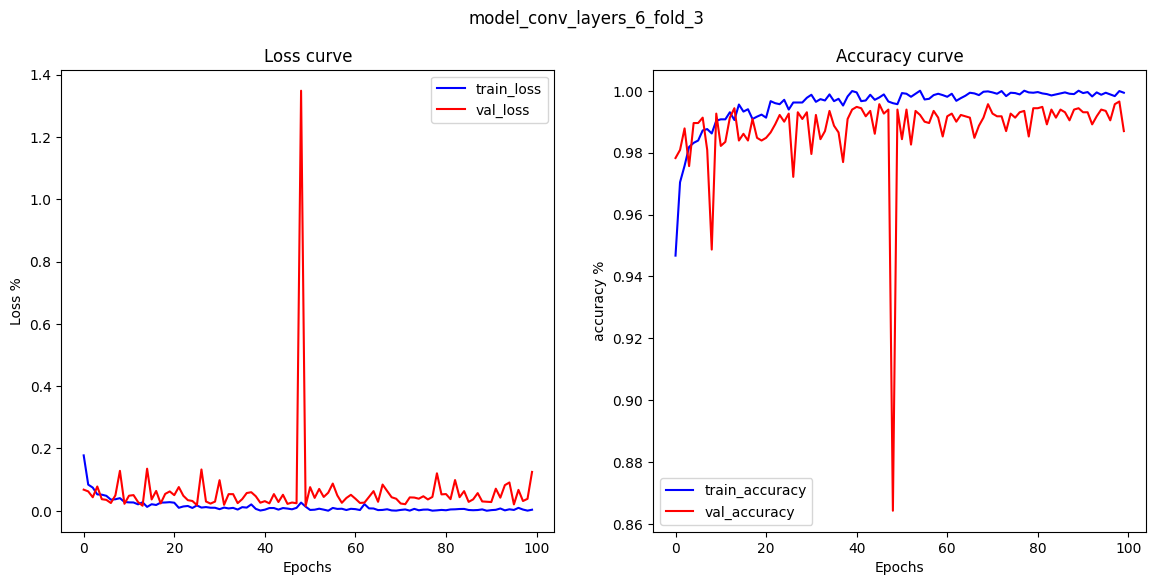



---- fold = 4 ---- conv layers = 6-------

72/72 [==============================] - 1s 11ms/step - loss: 0.0687 - accuracy: 0.9926
model_conv_layers = 6 Fold = 4 accuracy: 0.9926086664199829


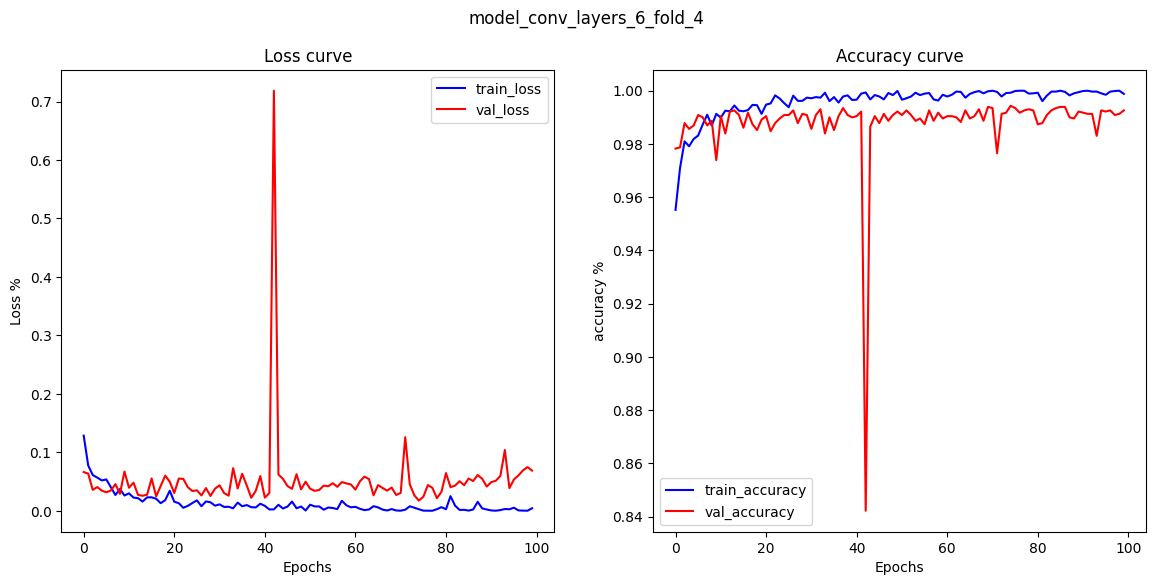



---- fold = 5 ---- conv layers = 6-------

72/72 [==============================] - 1s 11ms/step - loss: 0.0519 - accuracy: 0.9930
model_conv_layers = 6 Fold = 5 accuracy: 0.9930434823036194


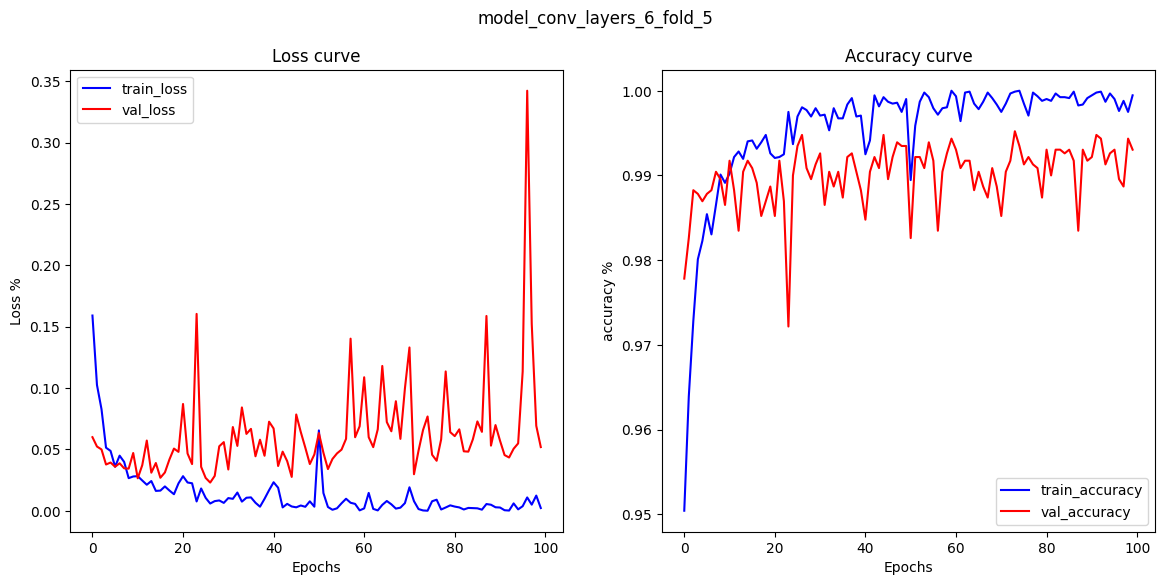

Mean Accuracy: 0.9920869469642639


In [ ]:
all_conv_layers = [1, 2, 3, 4, 5, 6]


for conv_layers in all_conv_layers:

    # Perform cross-validation
    fold_accuracy = []
    fold = 1

    for train_index, val_index in skf.split(X, y):
        X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


        # model = eegClassifier(input_shape, conv_layers)
        model = create_sequential_eeg_model(input_shape, conv_layers)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        log_file = f"model_conv_layers_{conv_layers}_fold_{fold}.log"
        model_name = f"model_conv_layers_{conv_layers}_fold_{fold}.h5"

        # Clear existing log handlers and close log files
        root_logger = logging.getLogger()
        for handler in root_logger.handlers:
            handler.close()
        root_logger.handlers.clear()

        # Create a separate log file for each model
        logger = init_logger(log_file, stdout=False)


        logger.info(f"\n\n---- fold = {fold} ---- conv layers = {conv_layers}-------\n")
        print(f"\n\n---- fold = {fold} ---- conv layers = {conv_layers}-------\n")

        # Define the checkpoint callback to save the best model
        checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

        # Train the model and capture the history
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                            callbacks=[checkpoint], verbose=0)

        # Log loss and accuracy
        for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
            logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
        for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
            logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


        # Evaluate the model on the test set
        loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
        fold_accuracy.append(accuracy)

        # Log fold accuracy
        logger.info(f"model_conv_layers = {conv_layers} Fold = {fold} accuracy: {accuracy}")

        print(f"model_conv_layers = {conv_layers} Fold = {fold} accuracy: {accuracy}")
        plot_loss_accuracy(history, f"model_conv_layers_{conv_layers}_fold_{fold}")
        # plot_accuracy(history)

        fold += 1

    # Calculate the average accuracy across all folds
    mean_accuracy = np.mean(fold_accuracy)
    print("Mean Accuracy:", mean_accuracy)